# see notes 5/24/20

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import math
import pandas as pd
import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
import glob
import os
from fnmatch import fnmatch
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Frequency-Encoding
###  increasing spatial frequency created by gradients over time

### also ignoring T1 or T2 decay, and slice encoding.

In [209]:
def yMagnitude(dB,gamma,t): #define M_y in rotating frame
    w0 = 0# (for relative phase, set it to zero)
    w =dB*gamma #larmor frequency in cycle/second
    My = np.cos(2*np.pi*w*t)
    return My
def xMagnitude(dB,gamma,t): #define M_x in rotating frame
    w0 = 0# (for relative phase, set it to zero)
    w = dB*gamma #larmor frequency in cycle/second
    Mx = np.sin(2*np.pi*w*t)
    return Mx

def setGradient(Bs,gamma,t): #do this for different delta B (i.e. gradient compared to center B =0)
    Mys = [] #all My for a particular time t, for all Bs in a row
    for i in range(len(Bs)):
        Myi = yMagnitude(Bs[i],gamma,t)
        Mys.append(Myi)
    return Mys

def run(Bs,gamma,ts): #do this for a set of times! (i.e. let it sit for t seconds..)
    Myts = [] #all Mys for all Bs, for all ts
    for i in range(len(ts)):
        Myt= setGradient(Bs,gamma,ts[i])
        Myts.append(Myt)
    return Myts

In [216]:
# for pretty
Bs2 = np.linspace(0,.4,201)
gamma2 = 1#rad/s*T
ts2 = np.linspace(0,10,9) #for 10 seconds
Ms = run(Bs2,gamma2,ts2)

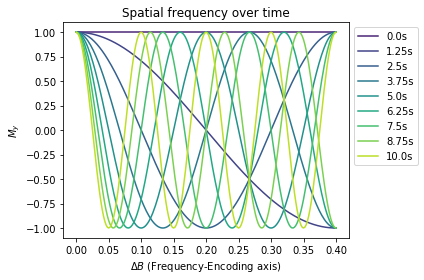

This shows the increasing spatial frequency (as a function of Delta B) over time!


In [217]:
for i in range(len(ts2)):
    with sns.color_palette("viridis",len(ts2)):
        pl.plot(Bs2,Ms[i],label = str(ts2[i])+'s')
pl.xlabel('$\Delta B$ (Frequency-Encoding axis)')
pl.ylabel('$M_y$')
pl.legend(bbox_to_anchor=(1, 1))
pl.title('Spatial frequency over time')
pl.tight_layout()
pl.savefig('/Users/neuroimaging/Desktop/SpatialFreq.png',format='png',dpi=300)
pl.show()

print('This shows the increasing spatial frequency (as a function of Delta B) over time!')

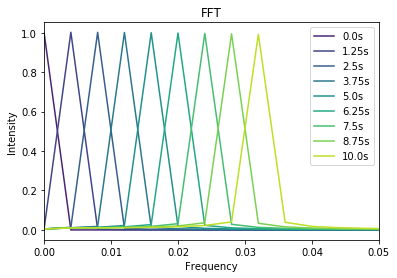

In [218]:
# for pretty
Bs2 = np.linspace(0,.8,201)
gamma2 = 1#rad/s*T
ts2 = np.linspace(0,10,9) #for 10 seconds
Ms = run(Bs2,gamma2,ts2)

Kx_freqs=[]
for i in range(len(ts2)):
    with sns.color_palette("viridis",len(ts2)):
        fft_My = np.fft.ifft(Ms[i])[:101]  #ifft of signal above, and only first half, removing mirror
        fft_mirrored = np.insert(np.flip(np.fft.ifft(Ms[i])[101:]), 0,0,axis=None)
        fft_My = fft_My + fft_mirrored #combine the two
        pl.plot(Bs2[:101],np.abs(fft_My),label = str(ts2[i])+'s')
        fft_split = fft_My[:101]
        max_x = Bs2[fft_split.argmax()] #get value of peaks, these are locations in k-space
        Kx_freqs.append(2*np.pi*max_x)
        
pl.legend(bbox_to_anchor=(1, 1))
pl.xlim(0,.05)
pl.title('FFT')
pl.xlabel('Frequency')
pl.ylabel('Intensity')
pl.savefig('/Users/neuroimaging/Desktop/SpatialFreq_FFT.png',format='png',dpi=300)

pl.show()

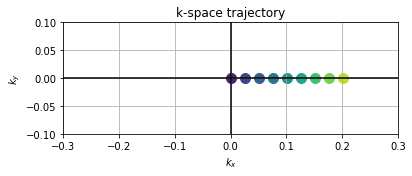

In [219]:
for i in range(len(ts2)):
    with sns.color_palette("viridis",len(ts2)):
        pl.scatter(Kx_freqs[i],0,s=100)
pl.axhline(y=0,color = 'black')
pl.axvline(x=0,color = 'black')
pl.xlim(-.3,.3)
pl.ylim(-.1,.1)
pl.xlabel('$k_x$')
pl.ylabel('$k_y$')
pl.grid(True)
pl.gca().set_aspect('equal', adjustable='box')
pl.title('k-space trajectory')
pl.savefig('/Users/neuroimaging/Desktop/SpatialFreq_kspace.png',format='png',dpi=300)

pl.show()

# Phase-encoding

### This includes both frequency encoding and phase encoding by adding $\phi (y)$.

In [285]:
def yMagnitude_kspace(dB,gamma,t, phi): #define M_y in rotating frame
    w0 = 0# (for relative phase, set it to zero)
    w =dB*gamma #larmor frequency in cycle/second
    My = np.cos(2*np.pi*w*t+phi)
    return My

def setGradient_kspace(Bs,gamma,t, phis): #do this for different delta B (i.e. gradient compared to center B =0)
    Mys = [] #all My for a particular time t, for all Bs in a row
    for j in range(len(phis)):
        My_phis = []
        for i in range(len(Bs)):
            Myi = yMagnitude_kspace(Bs[i],gamma,t,phis[j])
            My_phis.append(Myi)
        Mys.append(My_phis)
    return Mys


def make_phis(gamma,Bs,n,t): #make n phis where phi = gamma Gy t, where t is the amount of time the gradient is on. Also relative to the RF frequency.
    phis = []
    #assume t = 1, gamma = 1
    Bx = np.linspace(min(Bs),max(Bs),n) #go from min to max of gradient, in n steps
    for i in range(n):
        phi = 2*np.pi*gamma*Bx[i]*t
        phis.append(phi)
    return phis
    
    
def run_kspace(Bs,gamma,ts, phis): #do this for a set of times! (i.e. let it sit for t seconds..)
    Myts = [] #all Mys for all Bs, for all ts
    for i in range(len(ts)):
        Myt= setGradient_kspace(Bs,gamma,ts[i],phis)
        Myts.append(Myt)
    return Myts


In [291]:
# for pretty
Bs2 = np.linspace(0,.4,201)

Bs3 = np.linspace(0,.2,201) #from no difference to +.2, needs to be half to avoid looping! (only \pi, not 2\pi)
gamma3 = 1#rad/s*T
ts3 = np.linspace(1,5,2) #for 10 seconds
phis3 = make_phis(1,Bs3,9,1)

Ms3 = run_kspace(Bs2,gamma3,ts3, phis3)

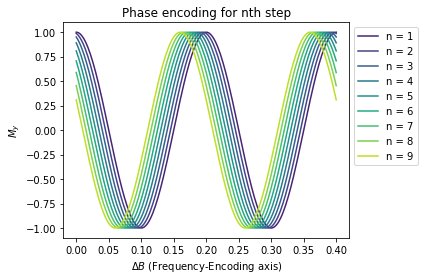

In [292]:
for i in range(len(phis3)):
    with sns.color_palette("viridis",len(phis3)):
        pl.plot(Bs2,Ms3[1][i],label = f'n = {i+1:.0f}')
pl.xlabel('$\Delta B$ (Frequency-Encoding axis)')
pl.ylabel('$M_y$')
pl.legend(bbox_to_anchor=(1, 1))
pl.title('Phase encoding for nth step')
pl.tight_layout()
pl.savefig('/Users/neuroimaging/Desktop/Spatial_phase.png',format='png',dpi=300)
pl.show()


#print('This shows the increasing spatial frequency (as a function of Delta B) over time!')

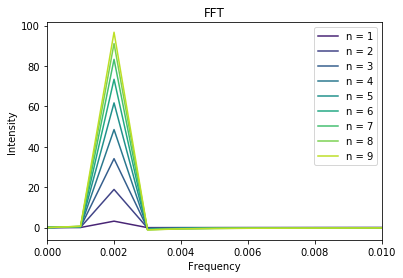

In [293]:
# for pretty
Ky_freqs=[]
for i in range(len(phis3)):
    with sns.color_palette("viridis",len(phis3)):
        fft_My = np.fft.fft(Ms3[1][i])[:101]  #ifft of signal above, and only first half, removing mirror
        #print(np.angle(fft_My))
        fft_mirrored = np.insert(np.flip(np.fft.ifft(Ms3[1][i])[101:]), 0,0,axis=None)
        fft_My = fft_My + fft_mirrored #combine the two
        pl.plot(Bs3[:101],np.imag(fft_My),label = f'n = {i+1:.0f}')
        fft_split = fft_My[:101]
        max_x = Bs3[fft_split.argmax()] #get value of peaks, these are locations in k-space
        Ky_freqs.append(2*np.pi*max_x)
        
        
pl.legend(bbox_to_anchor=(1, 1))
pl.xlim(0,.01)
pl.title('FFT')
pl.xlabel('Frequency')
pl.ylabel('Intensity')
pl.savefig('/Users/neuroimaging/Desktop/SpatialFreq_FFT_ky.png',format='png',dpi=300)

pl.show()

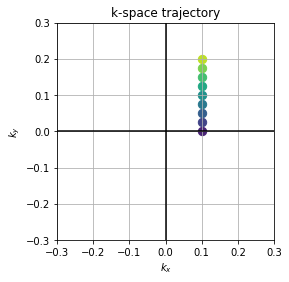

In [294]:
#for i in range(len(ts2)):
    #with sns.color_palette("viridis",len(ts2)):
        #pl.scatter(Kx_freqs[i],0,s=70)
#aling phase, it's for t = 5s frequency! (as ts3 = np.linspace(1,5,2) #for 10 seconds)
for i in range(len(phis3)):
    with sns.color_palette("viridis",len(phis3)):
        pl.scatter(Kx_freqs[4],phis3[i]/(2*np.pi),label = f'n = {i+1:.0f}',s=70)
        
pl.axhline(y=0,color = 'black')
pl.axvline(x=0,color = 'black')
pl.xlim(-.3,.3)
pl.ylim(-.3,.3)
pl.xlabel('$k_x$')
pl.ylabel('$k_y$')
pl.grid(True)
pl.gca().set_aspect('equal', adjustable='box')
pl.title('k-space trajectory')
pl.savefig('/Users/neuroimaging/Desktop/SpatialFreq_kspace_ky.png',format='png',dpi=300)

pl.show()

# now plots for dissertation for fun

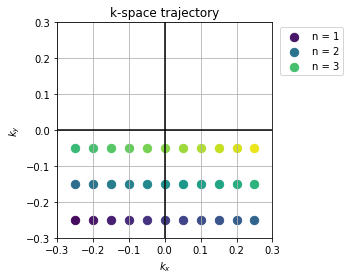

In [331]:
Kx_sample = np.linspace(-.25, .25, 11)

with sns.color_palette("viridis",11*3):
    for i in range(len(Kx_sample)):
        if i == 1:
            pl.scatter(Kx_sample[i],-.25,s=70,label = 'n = 1')
        else:
            pl.scatter(Kx_sample[i],-.25,s=70)
            

    for i in range(len(Kx_sample)):
        if i == 1:
            pl.scatter(Kx_sample[i],-.15,s=70,label = 'n = 2')
        else:
            pl.scatter(Kx_sample[i],-.15,s=70)

    for i in range(len(Kx_sample)):
        if i == 1:
            pl.scatter(Kx_sample[i],-.05,s=70,label = 'n = 3')
        else:
            pl.scatter(Kx_sample[i],-.05,s=70)
        
pl.axhline(y=0,color = 'black')
pl.axvline(x=0,color = 'black')
pl.xlim(-.3,.3)
pl.ylim(-.3,.3)
pl.xlabel('$k_x$')
pl.ylabel('$k_y$')
pl.legend(bbox_to_anchor=(1.35, 1))
pl.grid(True)
pl.gca().set_aspect('equal', adjustable='box')
pl.title('k-space trajectory')
pl.tight_layout()
pl.savefig('/Users/neuroimaging/Desktop/SpinWarp_Example.png',format='png',dpi=300)

pl.show()

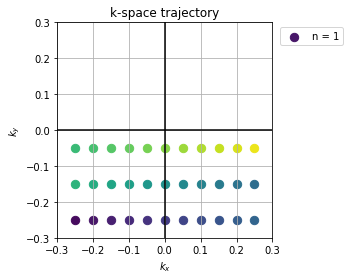

In [332]:
Kx_sample = np.linspace(-.25, .25, 11)
Kx_sample_flipped = np.flip(np.linspace(-.25, .25, 11))

with sns.color_palette("viridis",11*3):
    for i in range(len(Kx_sample)):
        if i == 1:
            pl.scatter(Kx_sample[i],-.25,s=70,label = 'n = 1')
        else:
            pl.scatter(Kx_sample[i],-.25,s=70)
            

    for i in range(len(Kx_sample)):
            pl.scatter(Kx_sample_flipped[i],-.15,s=70)

    for i in range(len(Kx_sample)):
            pl.scatter(Kx_sample[i],-.05,s=70)
        
pl.axhline(y=0,color = 'black')
pl.axvline(x=0,color = 'black')
pl.xlim(-.3,.3)
pl.ylim(-.3,.3)
pl.xlabel('$k_x$')
pl.ylabel('$k_y$')
pl.legend(bbox_to_anchor=(1.35, 1))
pl.grid(True)
pl.gca().set_aspect('equal', adjustable='box')
pl.title('k-space trajectory')
pl.tight_layout()
pl.savefig('/Users/neuroimaging/Desktop/EPI_Example.png',format='png',dpi=300)

pl.show()